In [1]:
%pip install  edge-ml

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
from edgeml import DatasetReceiver
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [4]:
# Load project object
project=DatasetReceiver("https://beta.edge-ml.org","02a4fad735d3308b68672ddb7593f047")
project.loadData()

In [5]:
# Store project object
pickle.dump(project, open("data_snapshot/project_css25.pkl","wb"))
project=pickle.load(open("data_snapshot/project_css25.pkl","rb"))

In [6]:
# Aggregation_list
filtered_dataframes = []

for d in project.datasets:

    # Only keep datasets with certain length
    if( (d.name == 'devicemotion') & (d.data.shape[0] > 0) & (d.timeSeries[0].end - d.timeSeries[0].start > 10000) ):
        
        # Remove noisy data at beginning and ending of recording
        cleaned_data = d.data.iloc[40:-40].dropna()

        # Add metadata columns
        enriched_data = cleaned_data.assign(**d.metaData)

        # Append to aggregation list
        filtered_dataframes.append(enriched_data)

# Concatenate individual dataframes
df_raw = pd.concat(filtered_dataframes)

In [7]:
# Drop testing data
df_filtered = df_raw[df_raw['activity'] != 'testing']

# Drop column mobile, Dummy encoding for column browser
df_encoded = pd.concat([df_filtered.drop(columns=["mobile","browser"]),pd.get_dummies(df_filtered[["browser"]])], axis=1)

# Encode activity as integer
df_encoded["activity"], labels = df_encoded["activity"].factorize()

# Set time as index
df_encoded_2 = df_encoded.set_index('time')

In [8]:
# Create custom mode function that returns only mode value (if there are multiple only the first one is returned)
def mode(x): 
    return (x.mode()[0])

# Create aggregation dictionary for groupby which defines aggregation for every column based on datatype
aggs={ 
      **dict.fromkeys(df_encoded_2.select_dtypes(exclude=[np.float32]).columns, [ mode ]),
      **dict.fromkeys(df_encoded_2.select_dtypes(include=[np.float32]).columns, ["mean","var","min","max","median"]),

        # Overwrite ealier entry for acitivity -> special treatment
      "activity": [mode,'count'],
}

# Do not consider for aggregation
del(aggs["participantId"])
aggs

{'activity': [<function __main__.mode(x)>, 'count'],
 'browser_Chrome': [<function __main__.mode(x)>],
 'browser_Safari': [<function __main__.mode(x)>],
 'acceleration.x': ['mean', 'var', 'min', 'max', 'median'],
 'acceleration.y': ['mean', 'var', 'min', 'max', 'median'],
 'acceleration.z': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.x': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.y': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.z': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.alpha': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.beta': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.gamma': ['mean', 'var', 'min', 'max', 'median']}

In [9]:
df_encoded_3 = df_encoded_2.groupby("participantId").rolling("1s").agg(aggs)
df_encoded_3.columns = [col[0] + "_" + col[1] if col [1] != "mode" else col[0] for col in df_encoded_3.columns]
df_encoded_3

activity  activity_count  \
participantId time                                                
10d83         2025-06-03 12:01:23.600       0.0             1.0   
              2025-06-03 12:01:23.616       0.0             2.0   
              2025-06-03 12:01:23.632       0.0             3.0   
              2025-06-03 12:01:23.649       0.0             4.0   
              2025-06-03 12:01:23.666       0.0             5.0   
...                                         ...             ...   
uspgb         2025-06-23 20:26:23.914       0.0            60.0   
              2025-06-23 20:26:23.930       0.0            61.0   
              2025-06-23 20:26:23.947       0.0            60.0   
              2025-06-23 20:26:23.964       0.0            60.0   
              2025-06-23 20:26:23.980       0.0            61.0   

                                       browser_Chrome  browser_Safari  \
participantId time                                                      
10d83         2025-06-03 12:01:23.600             1.0             0.0   
              2025-06-03 12:01:23.616             1.0             0.0   
              2025-06-03 12:01:23.632             1.0             0.0   
              2025-06-03 12:01:23.649             1.0             0.0   
              2025-06-03 12:01:23.666             1.0             0.0   
...                                               ...             ...   
uspgb         2025-06-23 20:26:23.914             1.0             0.0   
              2025-06-23 20:26:23.930             1.0             0.0   
              2025-06-23 20:26:23.947             1.0             0.0   
              2025-06-23 20:26:23.964             1.0             0.0   
              2025-06-23 20:26:23.980             1.0             0.0   

                                       acceleration.x_mean  \
participantId time                                           
10d83         2025-06-03 12:01:23.600             0.000000   
              2025-06-03 12:01:23.616             0.000000   
              2025-06-03 12:01:23.632            -0.033333   
              2025-06-03 12:01:23.649            -0.050000   
              2025-06-03 12:01:23.666            -0.060000   
...                                                    ...   
uspgb         2025-06-23 20:26:23.914             0.000000   
              2025-06-23 20:26:23.930             0.000000   
              2025-06-23 20:26:23.947             0.000000   
              2025-06-23 20:26:23.964             0.000000   
              2025-06-23 20:26:23.980             0.000000   

                                       acceleration.x_var  acceleration.x_min  \
participantId time                                                              
10d83         2025-06-03 12:01:23.600                 NaN                 0.0   
              2025-06-03 12:01:23.616            0.000000                 0.0   
              2025-06-03 12:01:23.632            0.003333                -0.1   
              2025-06-03 12:01:23.649            0.003333                -0.1   
              2025-06-03 12:01:23.666            0.003000                -0.1   
...                                                   ...                 ...   
uspgb         2025-06-23 20:26:23.914            0.000000                 0.0   
              2025-06-23 20:26:23.930            0.000000                 0.0   
              2025-06-23 20:26:23.947            0.000000                 0.0   
              2025-06-23 20:26:23.964            0.000000                 0.0   
              2025-06-23 20:26:23.980            0.000000                 0.0   

                                       acceleration.x_max  \
participantId time                                          
10d83         2025-06-03 12:01:23.600                 0.0   
              2025-06-03 12:01:23.616                 0.0   
              2025-06-03 12:01:23.632                 0.0   
              2025-06-03 12:01:23.649              

In [10]:
# Only keep rolling time windows with at least 60 data points
df_encoded_4 = df_encoded_3[df_encoded_3.activity_count >= 60 ].copy()

# Remove time from Index
df_encoded_4.index = df_encoded_4.index.droplevel(1)

# Format participantId as column 
df_encoded_4 = df_encoded_4.reset_index()
df_encoded_4

,participantId,activity,activity_count,browser_Chrome,browser_Safari,acceleration.x_mean,acceleration.x_var,acceleration.x_min,acceleration.x_max,acceleration.x_median,...,rotationRate.beta_mean,rotationRate.beta_var,rotationRate.beta_min,rotationRate.beta_max,rotationRate.beta_median,rotationRate.gamma_mean,rotationRate.gamma_var,rotationRate.gamma_min,rotationRate.gamma_max,rotationRate.gamma_median
0,10d83,0.0,60.0,1.0,0.0,0.008333,0.011624,-0.2,0.3,0.0,...,-0.355000,1.314720,-2.7,3.6,-0.45,0.015000,0.912483,-1.5,3.0,0.05
1,10d83,0.0,61.0,1.0,0.0,0.008197,0.011432,-0.2,0.3,0.0,...,-0.324590,1.349219,-2.7,3.6,-0.40,0.011475,0.898033,-1.5,3.0,0.00
2,10d83,0.0,60.0,1.0,0.0,0.008333,0.011624,-0.2,0.3,0.0,...,-0.300000,1.424746,-2.7,3.6,-0.40,0.038333,0.885116,-1.5,3.0,0.05
3,10d83,0.0,60.0,1.0,0.0,0.011667,0.011556,-0.2,0.3,0.0,...,-0.255000,1.473025,-2.7,3.6,-0.30,0.040000,0.882780,-1.5,3.0,0.05
4,10d83,0.0,60.0,1.0,0.0,0.015000,0.011466,-0.2,0.3,0.0,...,-0.201667,1.519489,-2.7,3.6,-0.30,0.006667,0.925040,-1.6,3.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108191,uspgb,0.0,60.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.185000,0.755534,-1.7,2.1,0.30,0.046667,0.002531,0.0,0.1,0.00
108192,uspgb,0.0,61.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.191803,0.745765,-1.7,2.1,0.30,0.045902,0.002525,0.0,0.1,0.00
108193,uspgb,0.0,60.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.160000,0.712271,-1.7,2.1,0.30,0.045000,0.002517,0.0,0.1,0.00
108194,uspgb,0.0,60.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.148333,0.691014,-1.7,2.1,0.30,0.043333,0.002497,0.0,0.1,0.00


In [11]:
# Drop NA values (0 NA values)
df_encoded_5 = df_encoded_4.dropna()

# Convert acitivity column back to labels 
df_encoded_5.activity = df_encoded_5.activity.apply(lambda x: labels[int(x)])

In [12]:
# Store features
pickle.dump(df_encoded_5,open("../features.pkl","wb"))

In [16]:
# Activity distribution before undersampling
df_encoded_5.groupby('activity').size()

activity
sitting     57102
standing     7610
walking     43484
dtype: int64

In [19]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample majority classes to get balanced distribution
X, y = RandomUnderSampler().fit_resample(df_encoded_5.drop(columns=["activity"]), df_encoded_5.activity)

# For Leave one group out
groups=X.participantId

# Drop participantId
X.drop(columns=["participantId"], inplace=True)

In [20]:
# Activity distribution after undersampling
pd.concat([X, y], axis=1).groupby('activity').size()

activity
sitting     7610
standing    7610
walking     7610
dtype: int64

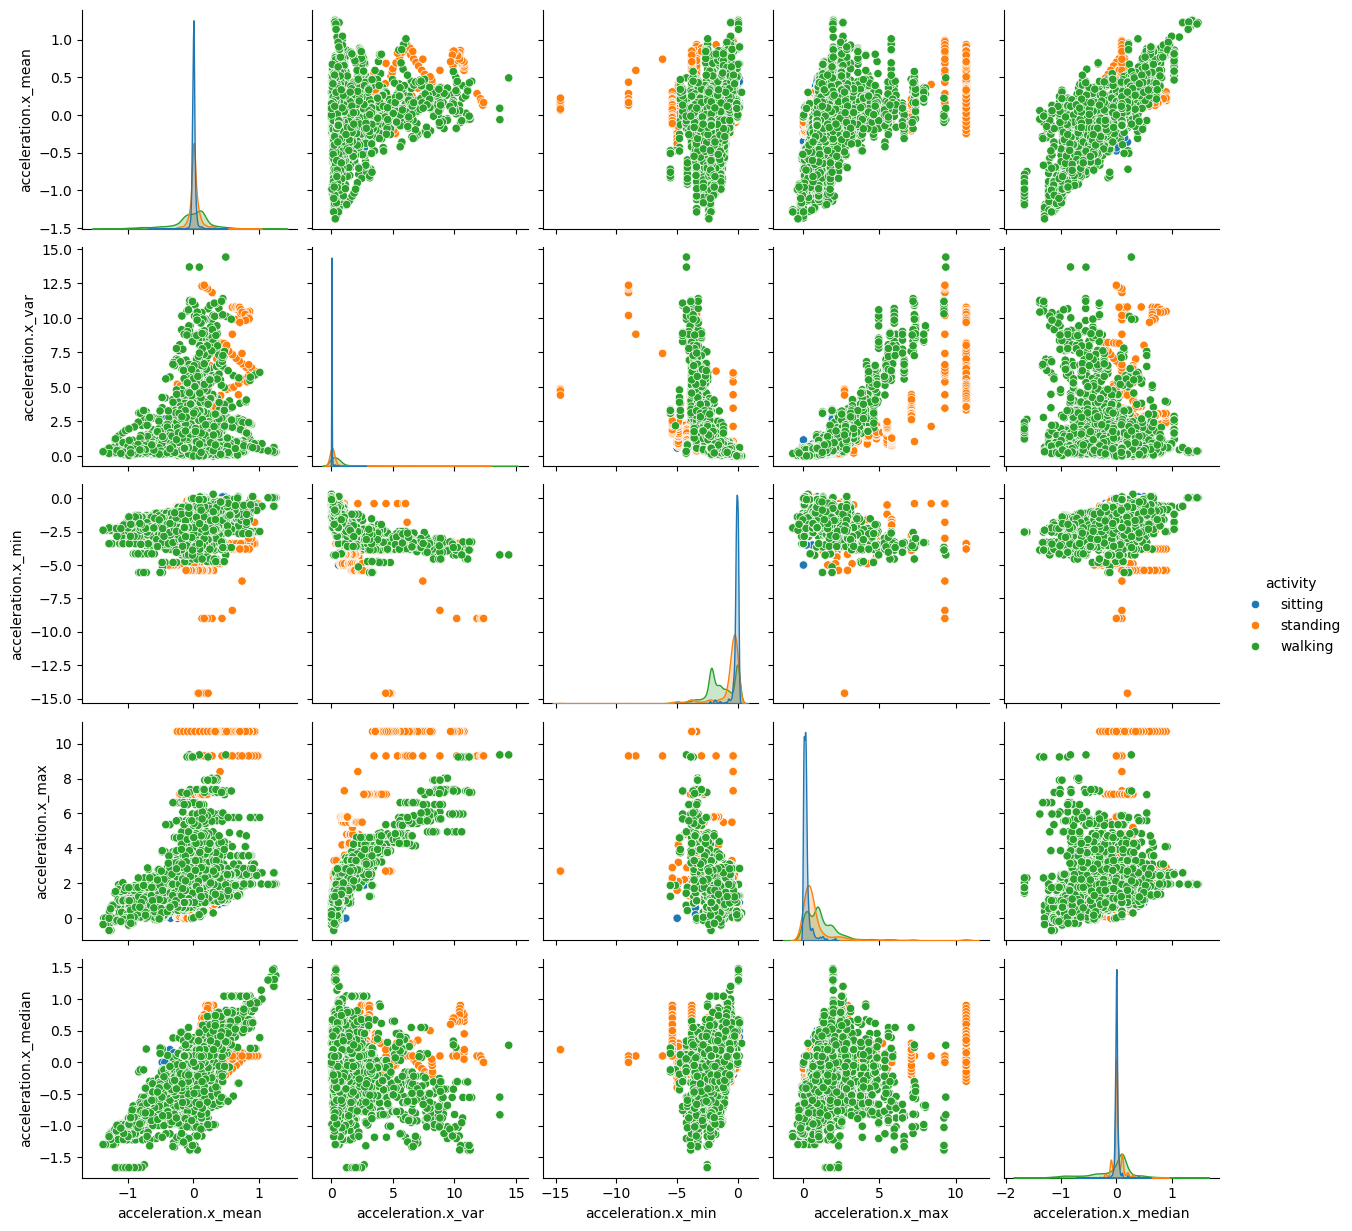

In [23]:
import seaborn as sns

# Only keep acceleration features
df_balanced = X[[col for col in X.columns if col.startswith("acceleration.x_")]].copy()
df_balanced["activity"] = y

# Creates scatter plots for all numeric variables, histograms on diagonal axis and colors points based on acitivity (hue=activity) 
sns.pairplot(df_balanced, hue="activity")

In [ ]:
# ...

In [29]:
import warnings
from sklearn.model_selection import cross_validate,LeaveOneGroupOut
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

# Define metrics for cross validation
classifier_metrics = [
    "accuracy", "balanced_accuracy", "precision_macro", "recall_macro",
    "f1_macro"
]

# Leave One Group Out CV
scores=pd.DataFrame(cross_validate(DecisionTreeClassifier(), X, y, cv=LeaveOneGroupOut(), groups=groups, scoring=classifier_metrics , verbose = True))

scores

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.514926,0.021039,0.483308,0.671106,0.593046,0.671106,0.508270
1,0.401823,0.062192,0.511920,0.499396,0.170772,0.332931,0.225749
2,0.521779,0.017277,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.563406,0.005249,0.083969,0.083969,0.333333,0.027990,0.051643
4,0.553015,0.013675,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.513901,0.016404,0.015748,0.015748,0.333333,0.005249,0.010336
6,0.572814,0.008846,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.570003,0.005231,0.833333,0.833333,0.500000,0.416667,0.454545
8,0.577822,0.008182,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.578866,0.007203,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
scores.mean()

fit_time                  0.537320
score_time                0.015686
test_accuracy             0.654631
test_balanced_accuracy    0.663964
test_precision_macro      0.571225
test_recall_macro         0.502066
test_f1_macro             0.503277
dtype: float64

In [31]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GroupKFold

# Recursive feature elimination with CV
# Fitting DecisionTree and removing least important feature at each step
rfecv = RFECV(estimator=DecisionTreeClassifier(), cv=GroupKFold(n_splits=5), step=1 , verbose=1, scoring='f1_macro').fit(X,y,groups=groups)

Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fe

In [33]:
# Print the optimal number of features and their indices

print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected features : %s" % rfecv.support_)

# 1 -> Selected, >1 -> Not selected, the lower the number the later during the process it got eliminated
print("Feature ranking : %s" % rfecv.ranking_)

Optimal number of features : 5
Selected features : [ True False False False False False False False False False False False
 False False False  True False False False False  True False False False
 False False False False False False False  True False False  True False
 False False False False False False False False False False False False]
Feature ranking : [ 1 20 44 13 43 24 17 31  6 10 26  7 11 29  3  1 42 18 41 39  1 12  5 27
 35  4  2 19 15 34  8  1 40 28  1  9 38 33 37 36 25 16 30 32 21 22 23 14]


In [34]:
cv_results = pd.DataFrame(rfecv.cv_results_)
cv_results

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,n_features
0,0.425514,0.078097,0.341810,0.447712,0.328270,0.483221,0.526557,1
1,0.337470,0.114343,0.226051,0.276703,0.260097,0.384346,0.540154,2
2,0.368411,0.184766,0.226051,0.173045,0.700629,0.340552,0.401776,3
3,0.395473,0.194702,0.226051,0.163373,0.578881,0.661922,0.347138,4
4,0.472641,0.272940,0.339076,0.101702,0.813592,0.763493,0.345344,5
5,0.395845,0.241708,0.225930,0.114481,0.808949,0.494593,0.335270,6
6,0.453544,0.200023,0.225839,0.336622,0.816589,0.480070,0.408601,7
7,0.394764,0.119218,0.225839,0.314856,0.576847,0.447654,0.408624,8
8,0.447417,0.177412,0.225839,0.359193,0.764045,0.433568,0.454441,9
9,0.440843,0.171942,0.225839,0.349418,0.746166,0.438957,0.443836,10


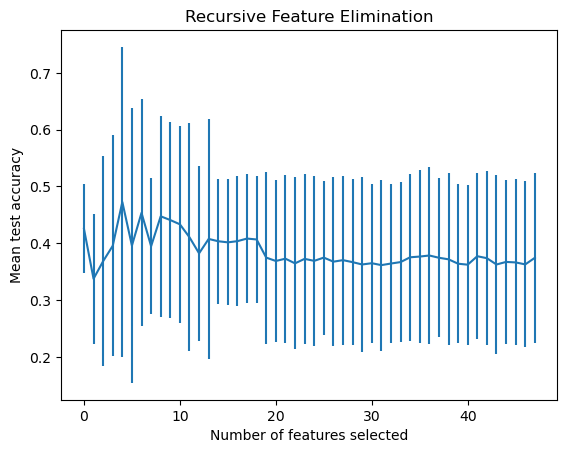

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results.index,
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()

In [37]:
df_feature = pd.concat([df_encoded_5.participantId,df_encoded_5.activity,df_encoded_5[rfecv.get_feature_names_out(X.columns)]],axis=1).dropna()
df_feature

,participantId,activity,activity_count,acceleration.z_min,accelerationIncludingGravity.x_min,accelerationIncludingGravity.z_max,rotationRate.alpha_var
0,10d83,sitting,60.0,-0.3,-0.9,5.6,4.486879
1,10d83,sitting,61.0,-0.3,-0.9,5.6,4.555568
2,10d83,sitting,60.0,-0.3,-0.9,5.6,4.674735
3,10d83,sitting,60.0,-0.3,-0.9,5.6,4.801186
4,10d83,sitting,60.0,-0.3,-0.9,5.6,4.811127
...,...,...,...,...,...,...,...
108191,uspgb,sitting,60.0,-0.2,-0.1,9.6,0.194404
108192,uspgb,sitting,61.0,-0.2,-0.1,9.6,0.191525
108193,uspgb,sitting,60.0,-0.2,-0.1,9.6,0.176497
108194,uspgb,sitting,60.0,-0.2,-0.1,9.6,0.168768
